In [1]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import nltk


In [2]:
# %pip install Sastrawi
# %pip install nltk
# %pip install PyStemmer
# nltk.download('punkt')

In [3]:
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory


In [4]:
df = pd.read_csv('product_reviews_dirty.csv')
df = df.iloc[:,1:3]
df.head()

,text,rating
0,Barang sesuai pesanan dan cepat sampai,5
1,Barang bagus harga murah,5
2,Paket rapi...mantap....cepat....sampe ke tujuan,5
3,ya saya puas dgn barangnya,5
4,Responya luar biasa b mantap,5


In [5]:
df.shape

(40607, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40607 entries, 0 to 40606
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40607 non-null  object
 1   rating  40607 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 634.6+ KB


Karena yang belum ada label positif dan negatif, maka penulis menggunakan rating dari review yang diberikan. rating 1 dan 2 dikategorikan sebagai negatif, rating 4 dan 5 sebagai positif, dan rating 3 dihapus. Distribusi label tiap tiap set bisa dilihat dibawah.

In [7]:
df = df[df['rating'] != 3]

<AxesSubplot:>

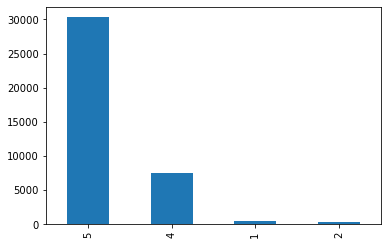

In [8]:
df['rating'].value_counts().plot(kind='bar')

In [9]:
df.loc[df.rating < 3, 'rating'] = 0
df.loc[df.rating > 3, 'rating'] = 1

Setelah dikelompokan, distribusi datanya lebih banyak kategori positif review. positif dan negatif direpresentasikan sebagai 0 dan 1. Melihat distribusi datanya, maka dataset yang akan diolah mengalami masalah imbalance. Hal ini menjadi semakin menarik untuk dimodelkan, karena untuk menguji apakah model bisa membedakan dengan baik mana review yang negatif walaupun datanya sedikit.

<AxesSubplot:>

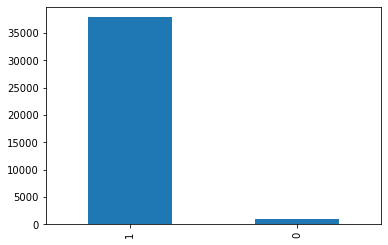

In [10]:
df['rating'].value_counts().plot(kind='bar')

In [11]:
df.shape

(38782, 2)

# Cleansing

Cleansing merupakan step data yang akan diolah harus dibersihkan terlebih dahulu. Proses cleansing dalam text mining bisa berupa menghapus tanda baca seperti koma, titik, tanda seru dan lain lain. Selain itu juga jika diperlukan stopwords, stemming, lemmatization, dan top frequent dan low frequent. Dalam pemodelan ini penulis menggunakan token unigram, panjang kata lebih dari 2 dan kata merupakan alpha numeric.

In [12]:
def remove_punctuation(word):
    for punkt in list(string.punctuation):
        word = word.replace(punkt, '')
        
    return word

In [13]:
df['text'] = df.text.apply(remove_punctuation)

In [14]:
def cleansing(text):
    text = text.lower()
    word_list = word_tokenize(text)
    word_list = [word for word in word_list if len(word) > 1]
    word_list = [remove_punctuation(word) for word in word_list]
    text = ' '.join(word_list)
    
    return text

In [15]:
# df['text'] = df.text.apply(cleansing)

In [16]:
# tfid_vectorizer = TfidfVectorizer()
# tfid_vectorizer.fit(df['text'])
# tfidf = tfid_vectorizer.transform

In [17]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df['text'], df['rating'],test_size=0.2, random_state=42)

In [18]:
# X_train = tfid_vectorizer.fit_transform(X_train)
# X_test = tfid_vectorizer.transform(X_test)

# Feature Extraction

Feature extraction merupakan sebuah step untuk mentransformasi teks kedalam angka atau yang bisa disebut feature representation. Terdapat beragam teknik untuk merubah teks kedalam array, tapi pada dasarnya kata kata unik dalam corpus itu yang menjadi featurenya. Feature extraction yang umum digunakan dalam sklearn adalah Count Vectorizer dan TF-IDF. Selain itu juga ada word embedding yang tidak dibahas dalam artikel ini. Count Vectorizer ini mudahnya menghitung semua kejadian kata dalam satu dokumen sedangkan tf-idf memberikan bobot masing masing kata.


In [19]:
cv = CountVectorizer()

In [20]:
X_train = cv.fit_transform(X_train)

In [21]:
X_test = cv.transform(X_test)

# Model

Tahap evaluasi ini untuk menentukan apakah model yang dibuat performanya sudah baik atau belum. biasanya model machine learning dikatakan bagus jika metrics yang dijadikan acuan > 85%. Angka threshold ini balik lagi ke projek awal seberapa tinggi score model ini harus dicapai.

### Naive Bayes

In [22]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train, y_train)
predictions_NB = Naive.predict(X_test)
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, y_test)*100)

Naive Bayes Accuracy Score ->  97.76975634910403


In [23]:
print(classification_report(y_test, predictions_NB))

              precision    recall  f1-score   support

           0       0.58      0.26      0.36       186
           1       0.98      1.00      0.99      7571

    accuracy                           0.98      7757
   macro avg       0.78      0.63      0.67      7757
weighted avg       0.97      0.98      0.97      7757



In [24]:
print('f1-score : ',f1_score(y_test, predictions_NB))
print('precisson : ',precision_score(y_test, predictions_NB))
print('recall : ', recall_score(y_test, predictions_NB))

f1-score :  0.9886520170547721
precisson :  0.982017200938233
recall :  0.995377096816801


In [25]:
confusion_matrix(y_test, predictions_NB, labels = [0,1])

array([[  48,  138],
       [  35, 7536]], dtype=int64)

### SVM

In [26]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=4, gamma='auto')
SVM.fit(X_train, y_train)
predictions_SVM = SVM.predict(X_test)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

SVM Accuracy Score ->  98.00180482145159


In [27]:
print(classification_report(y_test, predictions_SVM))

              precision    recall  f1-score   support

           0       0.63      0.41      0.50       186
           1       0.99      0.99      0.99      7571

    accuracy                           0.98      7757
   macro avg       0.81      0.70      0.74      7757
weighted avg       0.98      0.98      0.98      7757



In [28]:
print('f1-score : ',f1_score(y_test, predictions_SVM))
print('precisson : ',precision_score(y_test, predictions_SVM))
print('recall : ', recall_score(y_test, predictions_SVM))

f1-score :  0.9898059848733969
precisson :  0.9857217710243646
recall :  0.9939241843877955


In [29]:
confusion_matrix(y_test, predictions_SVM, labels = [0,1])

array([[  77,  109],
       [  46, 7525]], dtype=int64)

In [30]:
y_test.value_counts()

1    7571
0     186
Name: rating, dtype: int64

### Logistic Regression

In [31]:
Lr = LogisticRegression(C=1)
Lr.fit(X_train, y_train)
predictions_Lr = Lr.predict(X_test)
print("Logistic Regression Accuracy Score -> ",accuracy_score(predictions_Lr, y_test)*100)

Logistic Regression Accuracy Score ->  98.04047956684285


In [32]:
print(classification_report(y_test, predictions_Lr))

              precision    recall  f1-score   support

           0       0.68      0.34      0.45       186
           1       0.98      1.00      0.99      7571

    accuracy                           0.98      7757
   macro avg       0.83      0.67      0.72      7757
weighted avg       0.98      0.98      0.98      7757



In [33]:
print('f1-score : ',f1_score(y_test, predictions_Lr))
print('precisson : ',precision_score(y_test, predictions_Lr))
print('recall : ', recall_score(y_test, predictions_Lr))

f1-score :  0.9900236282488842
precisson :  0.9839530332681018
recall :  0.9961695945053494


### Random Forest

In [34]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)
predictions_rf = rf.predict(X_test)
print("Random Forest Accuracy Score -> ",accuracy_score(predictions_rf, y_test)*100)

Random Forest Accuracy Score ->  97.87288900348072


In [35]:
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

           0       0.86      0.13      0.23       186
           1       0.98      1.00      0.99      7571

    accuracy                           0.98      7757
   macro avg       0.92      0.57      0.61      7757
weighted avg       0.98      0.98      0.97      7757



In [36]:
print('f1-score : ',f1_score(y_test, predictions_rf))
print('precisson : ',precision_score(y_test, predictions_rf))
print('recall : ', recall_score(y_test, predictions_rf))

f1-score :  0.9892149813713315
precisson :  0.9791666666666666
recall :  0.9994716682076344


### Decision Tree

In [37]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
predictions_dt = dt.predict(X_test)
print("Decision Tree Accuracy Score -> ",accuracy_score(predictions_dt, y_test)*100)

Decision Tree Accuracy Score ->  97.2412014954235


In [38]:
print(classification_report(y_test, predictions_dt))

              precision    recall  f1-score   support

           0       0.41      0.35      0.38       186
           1       0.98      0.99      0.99      7571

    accuracy                           0.97      7757
   macro avg       0.70      0.67      0.68      7757
weighted avg       0.97      0.97      0.97      7757



In [39]:
print('f1-score : ',f1_score(y_test, predictions_dt))
print('precisson : ',precision_score(y_test, predictions_dt))
print('recall : ', recall_score(y_test, predictions_dt))

f1-score :  0.9858932102834542
precisson :  0.984076852217397
recall :  0.9877162858274997


### XgBoost

In [40]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
predictions_xgb = xgb.predict(X_test)
print("XGB Accuracy Score -> ",accuracy_score(predictions_xgb, y_test)*100)

[13:26:05] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\AIM\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGB Accuracy Score ->  98.05337114863994


In [41]:
print(classification_report(y_test, predictions_xgb))

              precision    recall  f1-score   support

           0       0.69      0.34      0.46       186
           1       0.98      1.00      0.99      7571

    accuracy                           0.98      7757
   macro avg       0.84      0.67      0.72      7757
weighted avg       0.98      0.98      0.98      7757



In [42]:
print('f1-score : ',f1_score(y_test, predictions_xgb))
print('precisson : ',precision_score(y_test, predictions_xgb))
print('recall : ', recall_score(y_test, predictions_xgb))

f1-score :  0.9900886117492617
precisson :  0.9840814196242171
recall :  0.9961695945053494


# WordCLoud

In [43]:
text = " ".join(review for review in df.text)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 2003960 words in the combination of all review.


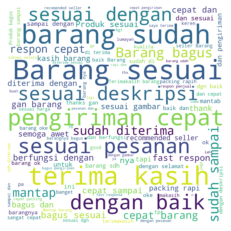

In [44]:
# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update(["barang"])

# Generate a word cloud image
wordcloud = WordCloud(width=1080,height=1080,max_words=100,min_font_size=5, stopwords=stopwords, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
from flask import Flask,render_template,url_for,request
import pandas as pd 
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
#from sklearn.externals import joblib


app = Flask(__name__, template_folder = 'template' )

# model = pickle.load(open('model_SV.pkl', 'rb'))

@app.route('/')
def home():
    return render_template('form_v2.html')

@app.route('/predict',methods=['POST'])
def predict():
    if request.method == 'POST':
        text = request.form['text']
        data = [text]
        vect = cv.transform(data).toarray()
        my_prediction = SVM.predict(vect)
    return render_template('form_v2.html', prediction = my_prediction)



if __name__ == '__main__':
    app.run(debug=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [18/Sep/2021 13:42:32] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Sep/2021 13:42:35] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Sep/2021 13:42:42] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Sep/2021 13:43:22] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Sep/2021 13:43:46] "POST /predict HTTP/1.1" 400 -
127.0.0.1 - - [18/Sep/2021 13:43:48] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Sep/2021 13:43:54] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Sep/2021 13:44:19] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Sep/2021 13:47:20] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Sep/2021 13:47:24] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Sep/2021 13:49:19] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Sep/2021 13:49:23] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Sep/2021 13:49:25] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Sep/2021 14:01:24] "POST /predict HTTP/1.1" 20

In [47]:
text = request.form['text']
data = [text]
vect = cv.transform(data).toarray()
my_prediction = SVM.predict(vect)
my_prediction

RuntimeError: Working outside of request context.

This typically means that you attempted to use functionality that needed
an active HTTP request.  Consult the documentation on testing for
information about how to avoid this problem.